In [1]:
import tensorflow as tf
import numpy as np
import csv
import os
import pandas as pd
import numpy as np
from tensorflow import keras
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.model_selection import KFold
from tensorflow.keras.layers import Dense, Input
import keras_tuner as kt
import gc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Training data
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"
#Got this dataset from here: https://keras.io/examples/timeseries/timeseries_anomaly_detection/

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

In [3]:

df_small_noise


,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120
...,...
2014-04-14 23:35:00,20.211195
2014-04-14 23:40:00,20.531041
2014-04-14 23:45:00,19.032127


In [4]:

len(df_small_noise)


4032

In [9]:

df_small_noise.tail()


,value
timestamp,
2014-04-14 23:35:00,20.211195
2014-04-14 23:40:00,20.531041
2014-04-14 23:45:00,19.032127
2014-04-14 23:50:00,21.798801
2014-04-14 23:55:00,18.682620


In [18]:
df_small_noise.index

DatetimeIndex(['2014-04-01 00:00:00', '2014-04-01 00:05:00',
               '2014-04-01 00:10:00', '2014-04-01 00:15:00',
               '2014-04-01 00:20:00', '2014-04-01 00:25:00',
               '2014-04-01 00:30:00', '2014-04-01 00:35:00',
               '2014-04-01 00:40:00', '2014-04-01 00:45:00',
               ...
               '2014-04-14 23:10:00', '2014-04-14 23:15:00',
               '2014-04-14 23:20:00', '2014-04-14 23:25:00',
               '2014-04-14 23:30:00', '2014-04-14 23:35:00',
               '2014-04-14 23:40:00', '2014-04-14 23:45:00',
               '2014-04-14 23:50:00', '2014-04-14 23:55:00'],
              dtype='datetime64[ns]', name='timestamp', length=4032, freq=None)

In [22]:
df_small_noise.reset_index(inplace=True)

In [23]:
df_small_noise

,timestamp,value
0,2014-04-01 00:00:00,18.324919
1,2014-04-01 00:05:00,21.970327
2,2014-04-01 00:10:00,18.624806
3,2014-04-01 00:15:00,21.953684
4,2014-04-01 00:20:00,21.909120
...,...,...
4027,2014-04-14 23:35:00,20.211195
4028,2014-04-14 23:40:00,20.531041
4029,2014-04-14 23:45:00,19.032127
4030,2014-04-14 23:50:00,21.798801


In [10]:

df_small_noise.min(), df_small_noise.max()


(value    18.000964
 dtype: float64,
 value    87.976128
 dtype: float64)

In [12]:
# List all available physical devices
physical_devices = tf.config.list_physical_devices()
print("Available physical devices:", physical_devices)

# Specifically check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 0:
    print(f"GPU is available: {gpus}")
else:
    print("GPU is not available.")

Available physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
os.getcwd()

'/Users/chidam_sp/PycharmProjects/pythonProject2/Computer vision, Time series, and NLP_TF certification/Numenta_Anomaly_Benchmark_(NAB)'

In [24]:
#Let's save a copy of this data here
df_small_noise.to_csv("/Users/chidam_sp/PycharmProjects/pythonProject2/Computer vision, Time series, and NLP_TF certification/Numenta_Anomaly_Benchmark_(NAB)/df_small_noise.csv")


In [25]:

def raw_data_to_input(data_source):
    # Initialize lists
    time_step = []
    nab_data = []

    # Open CSV file
    with open(data_source) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
  
    # Append row and sunspot number to lists
        for row in reader:
            time_step.append(int(row[0]))
            nab_data.append(float(row[2]))
        
    # Convert lists to numpy arrays
    time = np.array(time_step)
    series = np.array(nab_data)

    return series, time


In [27]:

series, time = raw_data_to_input("/Users/chidam_sp/PycharmProjects/pythonProject2/Computer vision, Time series, and NLP_TF certification/Numenta_Anomaly_Benchmark_(NAB)/df_small_noise.csv")


In [28]:

series


array([18.32491854, 21.97032718, 18.62480603, ..., 19.03212748,
       21.79880089, 18.68262037])

In [29]:
time

array([   0,    1,    2, ..., 4029, 4030, 4031])

In [30]:
len(series)

4032

In [38]:
len(series)*0.90

3628.8

In [57]:
len(series)*0.10

403.20000000000005

In [337]:
del series, time

In [199]:

def split_train_val_test(series):
    n = len(series)
    train_df = series[0:int(n*0.90)]
    val_df = series[int(n*0.90):]
    train_mean = train_df.mean()
    train_std = train_df.std()
    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    return train_df, val_df, train_mean, train_std


In [200]:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer=False):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) ##the None dimension invoked by window.batch is 
    ##of course necessary 

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    if shuffle_buffer:
        # # Shuffle the windows
        dataset = dataset.shuffle(shuffle_buffer)
    
    # # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
        
    return dataset


In [61]:
403/32

12.59375

In [201]:


# def denormalize_output(series):
#     n = len(series)
#     train_df = series[0:int(n*0.90)]
#     val_df = series[int(n*0.90):]
#     train_mean = train_df.mean()
#     train_std = train_df.std()
#     return train_mean, train_std

def data_split_transform(series, train_window_size, train_batch_size, val_window_size, val_batch_size, train_shuffle):
    train_series, val_series, train_mean, train_std = split_train_val_test(series)
    train_dataset = windowed_dataset(train_series, train_window_size, train_batch_size, train_shuffle)
    val_dataset = windowed_dataset(val_series, val_window_size, val_batch_size, False)
    return train_dataset, val_dataset, train_mean, train_std


In [202]:
train_window_size = 60
train_batch_size = 32
train_shuffle = 1000
val_window_size = 32
val_batch_size = 16
train_series, val_series, train_mean, train_std = data_split_transform(series, train_window_size, train_batch_size, val_window_size, val_batch_size, train_shuffle)


In [335]:
del train_series, val_series, val_batch_size, train_window_size, train_batch_size, train_shuffle, val_window_size

In [336]:
del model_build, history, cv_loop

In [324]:


# class Denormalize(tf.keras.layers.Layer):
#     def __init__(self, mean, std, **kwargs):
#         super(Denormalize, self).__init__(**kwargs)
#         self.mean = mean
#         self.std = std
# 
#     def call(self, inputs):
#         # Reverse the normalization equation: x_normalized = (x - mean) / std
#         return inputs * self.std + self.mean
    

def model_build():
    tf.random.set_seed(51)
    np.random.seed(51)

    model = tf.keras.models.Sequential([
            # tf.keras.layers.InputLayer(input_shape=(None, 1)),
            tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
            tf.keras.layers.LSTM(64, return_sequences=True),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.LSTM(32, return_sequences=True),
            tf.keras.layers.LSTM(16),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(16, activation="relu"),
            tf.keras.layers.Dense(8, activation="relu"),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(1),
            ])
    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.00076, momentum=0.0009)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
    return model



In [326]:


def cv_loop(train_series, val_series, patience):
    import datetime
    
    model = model_build()  # Function to create your model
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=patience,
                                                mode='min')
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint("/Users/chidam_sp/PycharmProjects/pythonProject2/Computer vision, Time series, and NLP_TF certification/Numenta_Anomaly_Benchmark_(NAB)/LSTM_Dense_model.h5", monitor='loss', mode='min', save_best_only=True)
    start_time = datetime.datetime.now()                  
    history = model.fit(train_series, epochs=20, callbacks=[early_stopping, model_checkpoint], validation_data=val_series, verbose=1) 
    
    end_time = datetime.datetime.now()
    print("Training time: ", end_time - start_time)
    return history


In [327]:


history = cv_loop(train_series, val_series, 5)



Epoch 1/20
    112/Unknown - 7s 38ms/step - loss: 0.5296 - mae: 1.0134

2024-04-23 13:31:27.772421: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12056034349550125202
2024-04-23 13:31:27.772435: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16829620005417250898
2024-04-23 13:31:27.772452: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 484938004519021503


112/112 [==============================] - 9s 52ms/step - loss: 0.5296 - mae: 1.0134 - val_loss: 0.4991 - val_mae: 0.9800
Epoch 2/20
  4/112 [>.............................] - ETA: 2s - loss: 0.5433 - mae: 1.0314

2024-04-23 13:31:29.267226: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18397891216394633360
2024-04-23 13:31:29.267242: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8810151055289938045
2024-04-23 13:31:29.267246: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1334921344558004383
2024-04-23 13:31:29.267249: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9490670947653661149
2024-04-23 13:31:29.267254: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3346198331953290045
2024-04-23 13:31:29.267259: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3725964620448193118
2024-04-23 13:31:29.267263: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

112/112 [==============================] - 3s 25ms/step - loss: 0.5229 - mae: 1.0098 - val_loss: 0.4989 - val_mae: 0.9846
Epoch 3/20
112/112 [==============================] - 3s 24ms/step - loss: 0.5165 - mae: 1.0060 - val_loss: 0.4934 - val_mae: 0.9822
Epoch 4/20
112/112 [==============================] - 3s 24ms/step - loss: 0.5038 - mae: 0.9945 - val_loss: 0.4859 - val_mae: 0.9756
Epoch 5/20
112/112 [==============================] - 3s 24ms/step - loss: 0.4976 - mae: 0.9881 - val_loss: 0.4789 - val_mae: 0.9688
Epoch 6/20
112/112 [==============================] - 3s 24ms/step - loss: 0.4892 - mae: 0.9791 - val_loss: 0.4719 - val_mae: 0.9620
Epoch 7/20
112/112 [==============================] - 3s 23ms/step - loss: 0.4805 - mae: 0.9700 - val_loss: 0.4641 - val_mae: 0.9544
Epoch 8/20
112/112 [==============================] - 3s 23ms/step - loss: 0.4748 - mae: 0.9639 - val_loss: 0.4541 - val_mae: 0.9443
Epoch 9/20
112/112 [==============================] - 3s 23ms/step - loss: 0.461

In [328]:
history.history

{'loss': [0.5296444296836853,
  0.5228776335716248,
  0.5164783596992493,
  0.5038443207740784,
  0.497586727142334,
  0.4891660213470459,
  0.4804645776748657,
  0.4748377799987793,
  0.46161919832229614,
  0.44951483607292175,
  0.4367614984512329,
  0.41474252939224243,
  0.3972317576408386,
  0.37091487646102905,
  0.3500983417034149,
  0.3228856325149536,
  0.3000807762145996,
  0.27655133605003357,
  0.25380179286003113,
  0.2355777621269226],
 'mae': [1.0134109258651733,
  1.0097671747207642,
  1.0059858560562134,
  0.9944567680358887,
  0.9880545139312744,
  0.9790879487991333,
  0.969969630241394,
  0.9638915061950684,
  0.9498296976089478,
  0.9361109137535095,
  0.9214367866516113,
  0.8954517841339111,
  0.8744987845420837,
  0.841503918170929,
  0.8141170740127563,
  0.7754799723625183,
  0.7410945296287537,
  0.7016032338142395,
  0.6592682003974915,
  0.6239404082298279],
 'val_loss': [0.499056339263916,
  0.4989144802093506,
  0.49339884519577026,
  0.4858652353286743,


In [291]:

def plot_learning_curve_metric(history, lower_limit, upper_limit):
    plt.plot(history['mae'], label='training_mae')
    plt.plot(history['val_mae'], label='validation_mae')
    plt.xlabel('Epoch')
    plt.ylabel('mae')
    plt.ylim([lower_limit, upper_limit])
    plt.legend(loc='lower right')

def plot_learning_curve_loss(history, lower_limit, upper_limit):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.ylim([lower_limit, upper_limit])
    plt.legend(loc='upper right')
    plt.show()


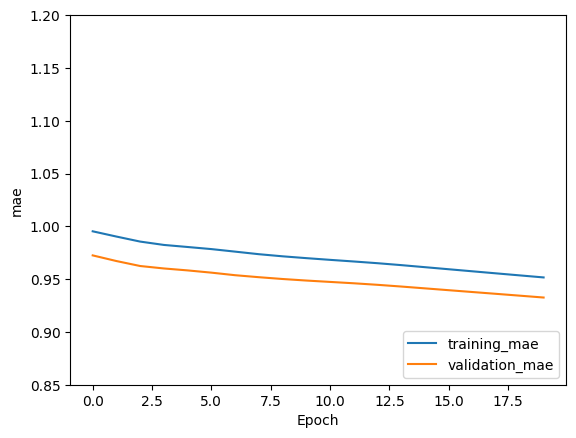

In [81]:

plot_learning_curve_metric(history.history, 0.85, 1.2)


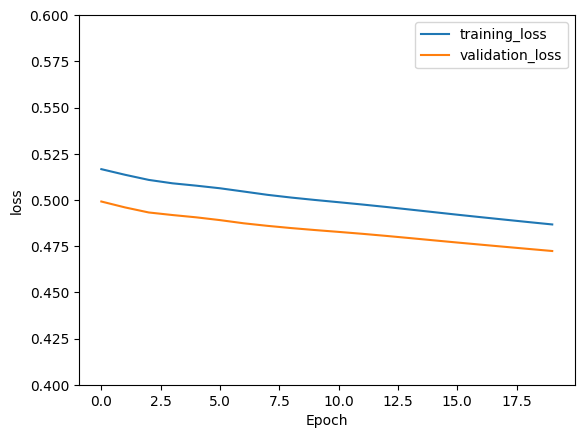

In [77]:

plot_learning_curve_loss(history.history, 0.4, 0.6)


In [ ]:
2.

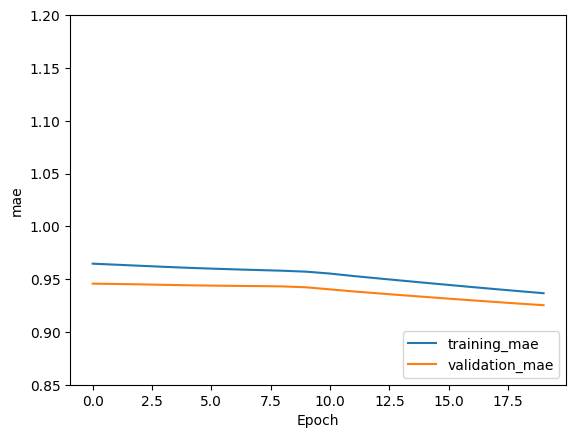

In [87]:
plot_learning_curve_metric(history.history, 0.85, 1.2)

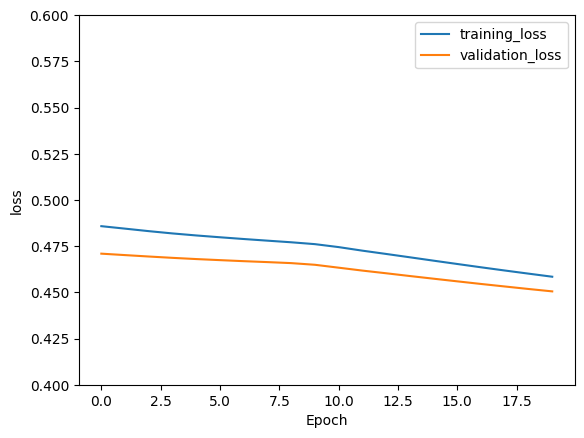

In [89]:
plot_learning_curve_loss(history.history, 0.4, 0.6)

In [ ]:
3.

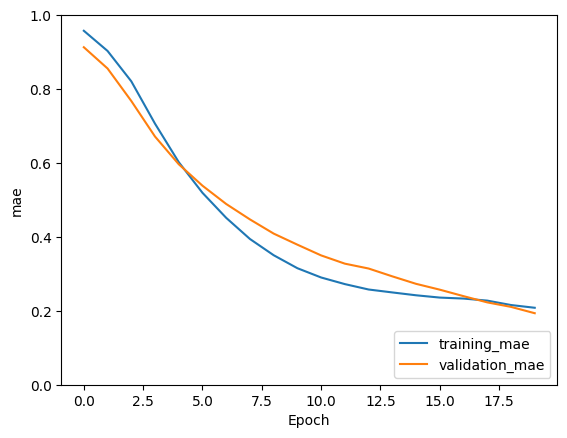

In [97]:
plot_learning_curve_metric(history.history, 0, 1)

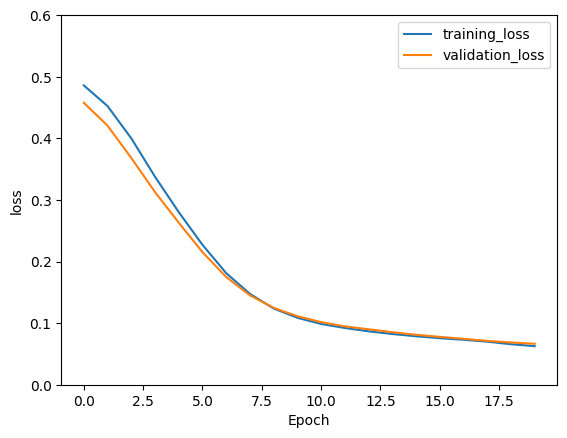

In [101]:

plot_learning_curve_loss(history.history, 0, 0.6)


In [ ]:
4.

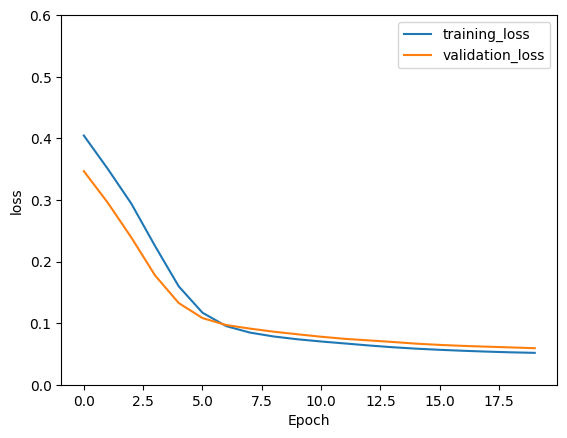

In [107]:
plot_learning_curve_loss(history.history, 0, 0.6)

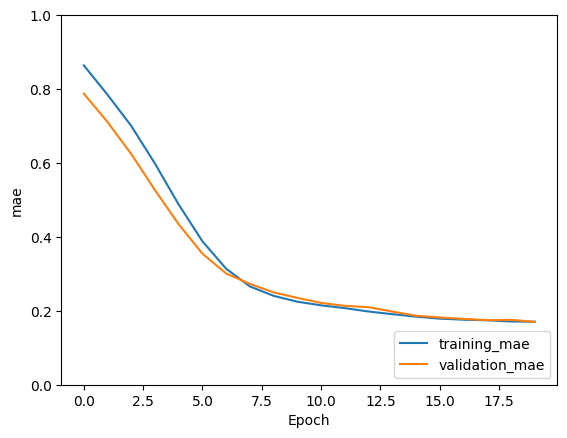

In [108]:
plot_learning_curve_metric(history.history, 0, 1)

In [ ]:
6. recent architecture- will continue tomorrow



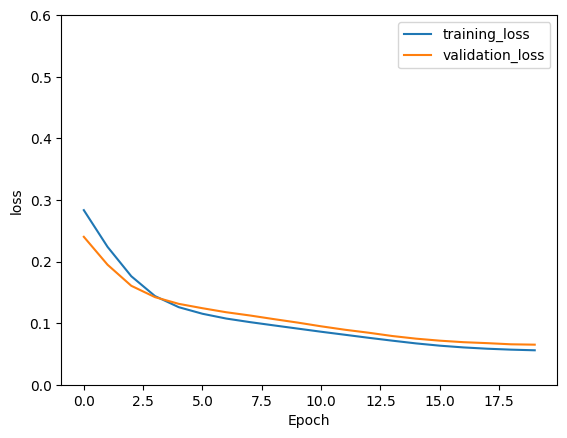

In [132]:
plot_learning_curve_loss(history.history, 0, 0.6)

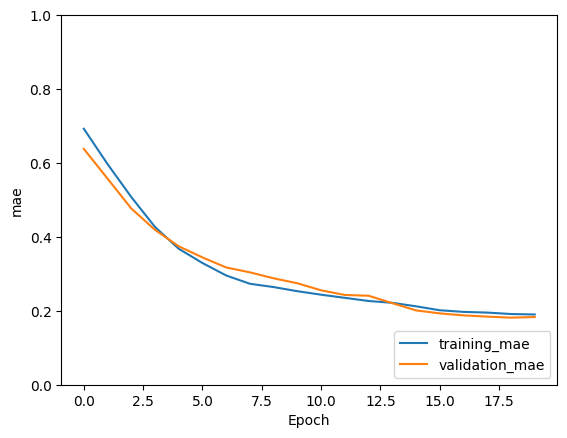

In [133]:
plot_learning_curve_metric(history.history, 0, 1)

In [ ]:
7.

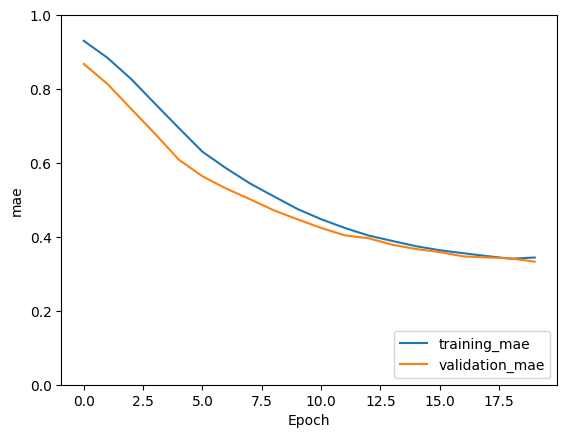

In [143]:

plot_learning_curve_metric(history.history, 0, 1)


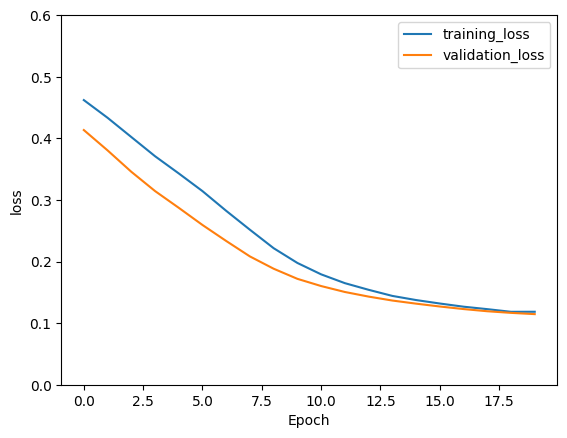

In [145]:

plot_learning_curve_loss(history.history, 0, 0.6)


In [ ]:
8.

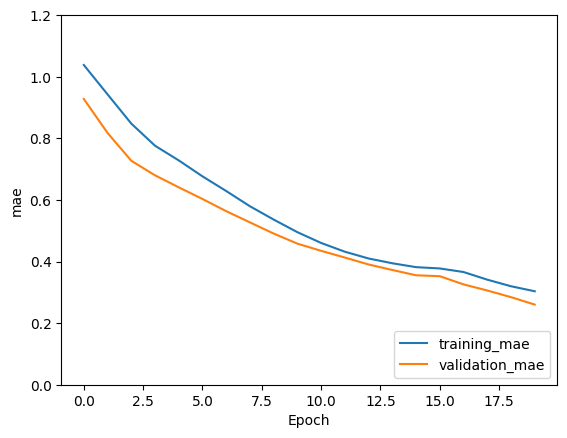

In [166]:
plot_learning_curve_metric(history.history, 0, 1.2)

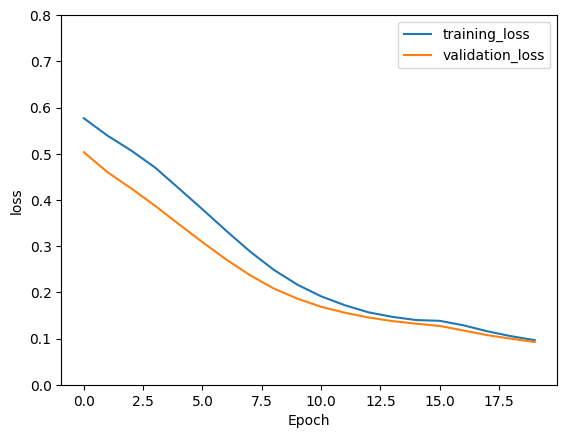

In [168]:

plot_learning_curve_loss(history.history, 0, 0.8)


In [ ]:
9.

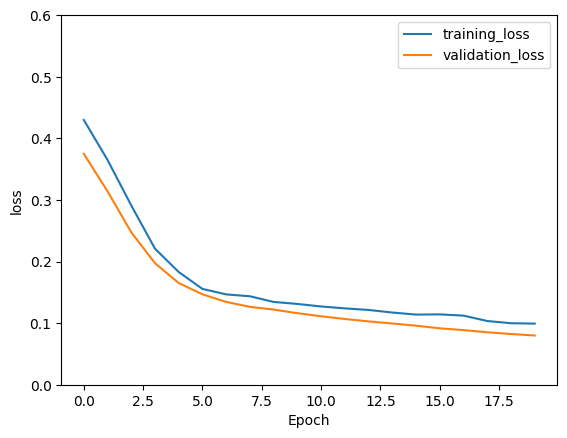

In [280]:
plot_learning_curve_loss(history.history, 0, 0.6)

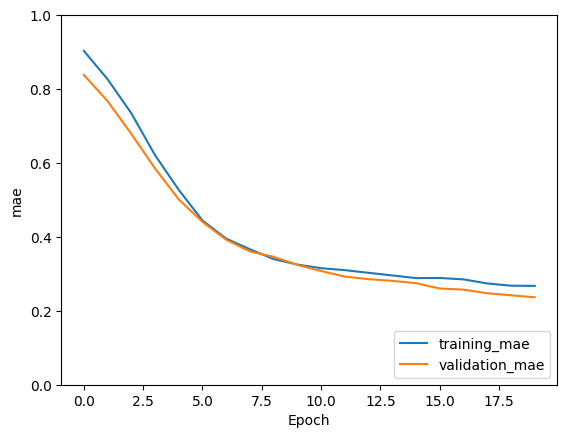

In [281]:

plot_learning_curve_metric(history.history, 0, 1)


In [ ]:
10. Did 100 epochs. Well done. Looks good! Can try to smooth out the variations in the curves but they are not too big to be bothered so can stop here.

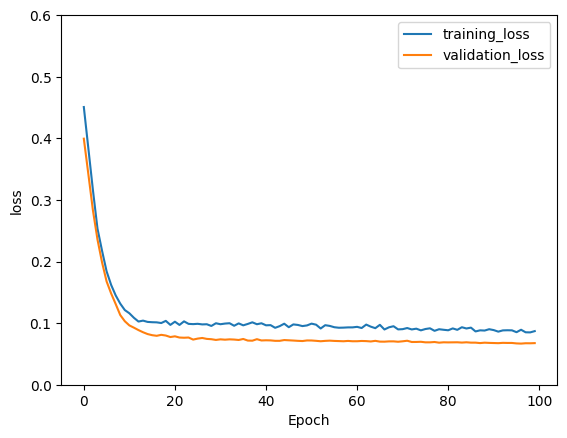

In [292]:

plot_learning_curve_loss(history.history, 0, 0.6)


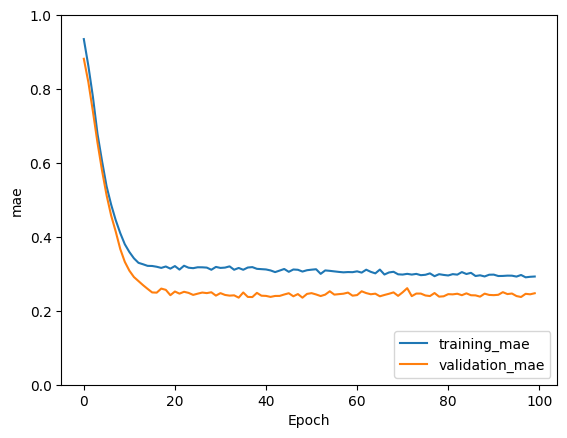

In [293]:

plot_learning_curve_metric(history.history, 0, 1)


11. Tried with the learning_rate and momentum from the hyperparameter tuning process. It's a good reminder that the tuning process is always going to work. Because it cannot always!

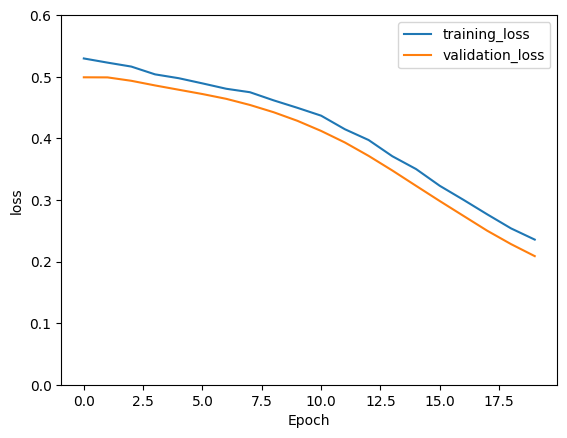

In [329]:
plot_learning_curve_loss(history.history, 0, 0.6)

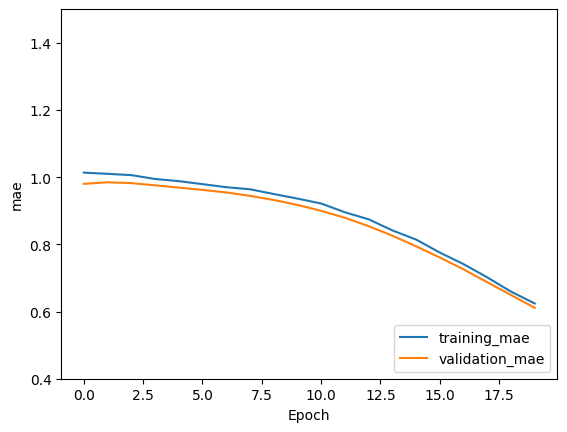

In [332]:
plot_learning_curve_metric(history.history, 0.4, 1.5)


Let's practice creating a hyperparameter tuning step


In [317]:
def model_builder(hp):
    
    model = tf.keras.models.Sequential([
            # tf.keras.layers.InputLayer(input_shape=(None, 1)),
            tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
            tf.keras.layers.LSTM(64, return_sequences=True),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.LSTM(32, return_sequences=True),
            tf.keras.layers.LSTM(16),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(16, activation="relu"),
            tf.keras.layers.Dense(8, activation="relu"),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(1),
            ])
    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=hp.Float('learning_rate', min_value=0.00075, max_value=0.00095, step=0.00001), momentum=hp.Float('momentum', min_value=0.0005, max_value=0.00095, step=0.0001))
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
    return model


In [305]:

# for i in np.arange(0.0005, 0.00095, 0.0001):
#     print(i)


In [318]:

def hp_tuning(train_series, val_series):
    import datetime
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    tuner = kt.BayesianOptimization(model_builder, objective='val_loss', max_trials=2, directory='hyperparameter_tuning', project_name='NAB_dataset_univariate_timeseries', overwrite=True)  
    start_time = datetime.datetime.now()
    tuner.search(train_series, validation_data=val_series, epochs=10, callbacks=[stop_early], verbose=1)
    end_time = datetime.datetime.now()
    print("Training time: ", end_time - start_time)
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    hypermodel = tuner.hypermodel.build(best_hps)
    return best_hps, hypermodel

    
    

In [334]:
del best_hps, hypermodel, hp_tuning, model_builder
gc.collect()

57498

In [320]:

best_hps, hypermodel = hp_tuning(train_series, val_series)


Trial 2 Complete [00h 00m 23s]
val_loss: 0.5012637376785278

Best val_loss So Far: 0.4539468288421631
Total elapsed time: 00h 00m 57s
Training time:  0:00:56.749709


In [321]:

for hp in best_hps.space:
  print(f"{hp.name}: {best_hps.get(hp.name)}")


learning_rate: 0.00076
momentum: 0.0009



Summary
We don't have to follow through the process after the tuning step as we clearly see that the parameter values we achieved through the tuning process are not optimal. Because we already have a good performing model we can go ahead with that. It's a clear reminder that hyperparameter tuning process is not the answer always.


In [333]:

from tensorflow.keras.backend import clear_session
clear_session()


In [340]:
gc.collect()

14010